## If I have seen further it is by standing on ye sholders of Giants
That's Sir Isaac Newton by the way :-)

One of the great things about recent advances in machine learning has been the willingness of folks to share what they build. There is a strong spirit of openness and that comes to us in for form of academic papers, source code.... and pre-trained models.

Being quite a lazy person, my natural inclination given the problem at hand, is to use some of these pre-trained models to perform our classification. The advantageof pre-trained models is that someone has spent a bunch of time/money/electricity to train them on a dataset that is typically much larger than my own.

In this notebook I aim to share a couple of approaches to _transfer learning_ using the common Keras framework. We'll cover;

- Bottlenecking
- Fine-tuning

Before we get to that though, we'll also cover off an approach called _data augmentation_ that is particularly useful when we have a small dataset (which we do).


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle
import itertools

#Inline Matplot graphics into the notebook
%matplotlib inline 


# From: https://gist.github.com/fabeat/6621507
# Using the version in the comments to the Gist
# Best practice default is using Bicubic rather than Antialias per http://pillow.readthedocs.io/en/3.0.x/releasenotes/2.7.0.html#default-filter-for-thumbnails
def scale(image, max_size=(128,128), method=Image.BICUBIC):
    """
    resize 'image' to 'max_size' keeping the aspect ratio
    and place it in center of white 'max_size' image
    """
    image.thumbnail(max_size, method)
    offset = (int((max_size[0] - image.size[0]) // 2), int((max_size[1] - image.size[1]) // 2))
    back = Image.new("RGB", max_size, "white")
    back.paste(image, offset)

    return back






### Data Augmentation

Data augentation is an approach that we can use to generate additional training data by performing transformations on the data that we already have. It's well suited to Convlutional Neural Networks (with pooling) which are able to deal with (and benefit from) training on transformed and scaled input examples. We will build a more generalizable model by taking our rather regular dataset and using augmentation to create additional transformed examples.

There are a bunch of approaches to augmentation and so the one you choose will probably reflect your tastes a bit. Below we use a standalone library called [_Augmentor_](https://github.com/mdbloice/Augmentor) to generate new examples into a seperate directory. The _keras_ ML meta-library also provides [native support](https://keras.io/preprocessing/image/) for augmentation and Augmentor can also interface with keras to generate samples on the fly.


In [4]:
import shutil

shutil.rmtree('../gear_images_augmented')
os.makedirs('../gear_images_augmented', exist_ok=True)

import Augmentor
p = Augmentor.Pipeline("../gear_images",output_directory="../gear_images_augmented")
p.random_distortion(probability=.3, grid_width=4, grid_height=4, magnitude=8)
p.rotate(probability=.8, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.1, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)
p.crop_random(probability=0.1, percentage_area=0.3)
p.sample(10000)

Processing 31XWPzBqcv..._QL65_.jpg:   0%|          | 4/10000 [00:00<05:22, 31.03 Samples/s]

Initialised with 2127 image(s) found.
Output directory set to ../gear_images/../gear_images_augmented.

### Bottlenecking
This technique is often also called _featurization_. The term Bottlenecking comes from it's genesis in auto-encoders and so we'll explain it in that context below. At a high level, Bottlenecking uses a pre-trained neural network to generate features (a reduced dimensionality representation) and then we use those features to train a seperate machine learning model. Importantly, we do not train or retrain the primary neural network, we rely on the pretrained weights and simply run inference through it.

#### The Genesis of Bottlenecking in Autoencoders
[Autoencoders](https://en.wikipedia.org/wiki/Autoencoder) are an un-supervised machine learning technique that train a model to form a 'compressed' representation of data. Think of an auto-encoder as a way of using un-supervised learing to build a model for dimensionality reduction.

![Autoencoder](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) 
Image from Wikipedia

'Bottlenecking' refers to the use of the output values in the bottleneck of the model as a dimensionally reduced representation of the data. More generally, the term 'Bottlenecking' is now used to refer to situations where we remove one or more layers from a trained neural network and use the output from the model up until those layers. In our cse below were using the ResNet 50 model architechture and our Bottleneck layer has 2048 units.

Keras makes it _super-easy_ to undertake bottlenecking as it provides a library of pre-trained models that we can retrieve automatically. We're using the features to train a simple fully connected neural ntwork below, but, you may want to try other models. This featurization approach is also excellent for situations when you want to combine data from the image alongside structured or tabular data into a single model.

In [12]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image as kimage
from keras.applications.resnet50 import preprocess_input, decode_predictions

#Fetch a pretrained ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False)


In [15]:
gear_images_dir = "../gear_images"
data = list()
hddata = list()
labels = list()
images = list()
features = list()
for directory in os.listdir(gear_images_dir):
    current_dir = gear_images_dir + '/' + directory
    #print('Loading images from: {}'.format(current_dir))
    for imgName in os.listdir(os.fsencode(current_dir)):
        #print('Loading: {}'.format(os.fsdecode(imgName)))
        image = Image.open(current_dir + '/' + os.fsdecode(imgName)) #Open as greyscale
        image = ImageOps.equalize(scale(image))
        images.append(image)
        data.append(np.asarray(image.convert('L')).flatten())
        labels.append(directory)
        
        #Featurize via ResNet50
        img = kimage.load_img(current_dir + '/' + os.fsdecode(imgName), target_size=(224, 224))
        x = kimage.img_to_array(img)
        hddata.append(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features.append(resnet50_model.predict(x)) features.append(resnet50_model.predict(x))
        
    print('Done')   

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


So now we have run an inference across all of the images and we have the 2048 features for each. These represent the outputs of the 2nd to top layer of the model, i.e. the bottlenext point.

In [17]:
data_array = np.asarray(data)
print(data_array.shape)

hddata_array = np.asarray(hddata)
print(hddata_array.shape)

label_array = np.asarray(labels)
print(label_array.shape)

feature_array = np.asarray(np.squeeze(features))
print(feature_array.shape)

num_classes= len(list(set(labels)))
print(num_classes)

(2129, 16384)
(2129, 224, 224, 3)
(2129,)
(2129, 2048)
12


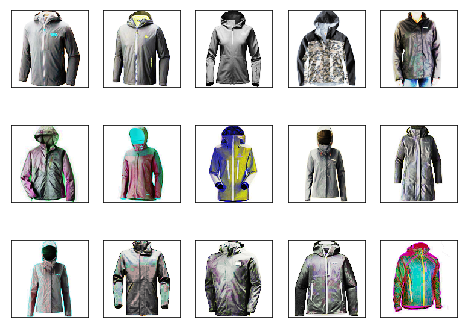

In [18]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i], cmap=plt.cm.bone)
    

In [19]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
le.fit(label_array)
encoded_label_array = le.transform(label_array)

In [20]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_array,
        encoded_label_array, random_state=0)

X_feat_train, X_feat_test, y_feat_train, y_feat_test = train_test_split(feature_array,
        encoded_label_array, random_state=0)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(hddata_array,
        encoded_label_array, random_state=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(X_feat_train.shape, X_feat_test.shape)
print(y_feat_train.shape, y_feat_test.shape)
print(X_hd_train.shape, X_hd_test.shape)
print(y_hd_train.shape, y_hd_test.shape)

(1596, 16384) (533, 16384)
(1596,) (533,)
(1596, 2048) (533, 2048)
(1596,) (533,)
(1596, 224, 224, 3) (533, 224, 224, 3)
(1596,) (533,)


Train a simple fully connected model on the features we bottlenecked out. We can see how much of a problem that overfitting is. By playing with the hyper-parameters; e.g. try changing numberof units in the layers.

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = None
model = Sequential()
model.add(Dense(64,input_dim=len(X_feat_train[1,:])))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

model.fit(X_feat_train, y_feat_train,
          epochs=50,
          batch_size=30,
          validation_data=(X_feat_test, y_feat_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 136,076
Trainable params: 136,076
Non-trainable params: 0
_________________________________________________________________
Train on 1596 samples, validate on 533 samples
Epoch 1/50
1596/1596 [==============================] - 3s 2ms/step - loss: 1.0551 - acc: 0.6736 - val_loss: 0.1124 - val_acc: 0.9756
Epoch 2/50
1596/1596 [==============================] - 1s 871us/step - loss: 0.1884 - 

### Fine Tuning

Based on the Keras [applications sample](https://keras.io/applications/) but using ResNet and not Inception.

In fine tuning we retrieve the pre-trained model less the top-most layer. We then add a new fully connected layer and output layer. We lock all the lower layers and train for a few epochs to initialize the weights into the new output layers.

Then we unlock some of the top layers of the model and retrain. We keep the bottom most layers locked as these have learnt lower level visual constructs e.g. edges etc... We want to take advantage of the pre-trained lower layers and then fine tumne the top layers.

In [23]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = resnet50_model #As we already loaded the model above.

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- of size num_classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the new top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

# train the model on the new data for a few epochs
model.fit(X_hd_train, y_hd_train,
          epochs=5,
          batch_size=30,
          validation_data=(X_hd_test, y_hd_test))


Train on 1596 samples, validate on 533 samples
Epoch 1/5
1596/1596 [==============================] - 708s 444ms/step - loss: 2.4966 - acc: 0.7575 - val_loss: 1.1496 - val_acc: 0.9043
Epoch 2/5
1596/1596 [==============================] - 697s 436ms/step - loss: 0.9700 - acc: 0.9167 - val_loss: 1.6711 - val_acc: 0.7917
Epoch 3/5
1596/1596 [==============================] - 699s 438ms/step - loss: 0.9296 - acc: 0.9298 - val_loss: 1.5688 - val_acc: 0.8724
Epoch 4/5
1596/1596 [==============================] - 693s 435ms/step - loss: 0.6093 - acc: 0.9380 - val_loss: 0.1129 - val_acc: 0.9794
Epoch 5/5
1596/1596 [==============================] - 701s 439ms/step - loss: 0.0507 - acc: 0.9875 - val_loss: 0.3879 - val_acc: 0.9437


Let's dump the layers out so that we can work out what we might unlock. We can then  refer to the [ResNet-50 model architechture](https://github.com/KaimingHe/deep-residual-networks#models) to determine which layers we'll unlock. There is no hard and fast rule here so you'll need to experiment... yet aother hyper-parameter to tune I am afraid!

In [24]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_50
5 max_pooling2d_2
6 res2a_branch2a
7 bn2a_branch2a
8 activation_51
9 res2a_branch2b
10 bn2a_branch2b
11 activation_52
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_17
17 activation_53
18 res2b_branch2a
19 bn2b_branch2a
20 activation_54
21 res2b_branch2b
22 bn2b_branch2b
23 activation_55
24 res2b_branch2c
25 bn2b_branch2c
26 add_18
27 activation_56
28 res2c_branch2a
29 bn2c_branch2a
30 activation_57
31 res2c_branch2b
32 bn2c_branch2b
33 activation_58
34 res2c_branch2c
35 bn2c_branch2c
36 add_19
37 activation_59
38 res3a_branch2a
39 bn3a_branch2a
40 activation_60
41 res3a_branch2b
42 bn3a_branch2b
43 activation_61
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_20
49 activation_62
50 res3b_branch2a
51 bn3b_branch2a
52 activation_63
53 res3b_branch2b
54 bn3b_branch2b
55 activation_64
56 res3b_branch2c
57 bn3b_branch2c
58 add_21
59 activation_65
60 res3c_branch2a
61 bn3c_branch2

Let's unlock from the Residual 5a branches up. So everything above the 4f Relu activation which is everything > 142

In [26]:
for layer in model.layers[:141]:
   layer.trainable = False
for layer in model.layers[142:]:
   layer.trainable = True

#Recompile and train low and slow.
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Now fine tune for 20 epochs.... again... overfitting is the big issue here
model.fit(X_hd_train, y_hd_train,
          epochs=5,
          batch_size=30,
          validation_data=(X_hd_test, y_hd_test))

Train on 1596 samples, validate on 533 samples
Epoch 1/5
1596/1596 [==============================] - 821s 515ms/step - loss: 0.0357 - acc: 0.9875 - val_loss: 0.1481 - val_acc: 0.9756
Epoch 2/5
1596/1596 [==============================] - 803s 503ms/step - loss: 0.0288 - acc: 0.9906 - val_loss: 0.1320 - val_acc: 0.9794
Epoch 3/5
1596/1596 [==============================] - 798s 500ms/step - loss: 0.0132 - acc: 0.9956 - val_loss: 0.1196 - val_acc: 0.9831
Epoch 4/5
1596/1596 [==============================] - 801s 502ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.1126 - val_acc: 0.9850
Epoch 5/5
1596/1596 [==============================] - 799s 501ms/step - loss: 0.0114 - acc: 0.9950 - val_loss: 0.1091 - val_acc: 0.9869
